Import TensorFlow

In [1]:
import tensorflow as tf

Download Sunspot Activity Data

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /content/sunspots.csv

--2022-09-25 10:33:43--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.213.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.213.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/content/sunspots.csv’

/content/sunspots.c 100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2022-09-25 10:33:43 (95.5 MB/s) - ‘/content/sunspots.csv’ saved [70827/70827]



Function to plot time series data against time

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

**Load data into lists of time steps and sunspots**

*   convert data to np arrays
*   plot the data   


In [4]:
with open('/content/sunspots.csv', 'r') as f:
  for i in range(5):
    print(f.readline(), end = "")

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8


In [5]:
import csv
series  = []

with open("/content/sunspots.csv", "r") as f:
  reader = csv.reader(f, delimiter = ",")
  next(reader)
  for row in reader:
    series.append(float(row[2]))


In [6]:
series = np.array(series)
time = np.array(range(len(series)))

series.shape, time.shape

((3235,), (3235,))

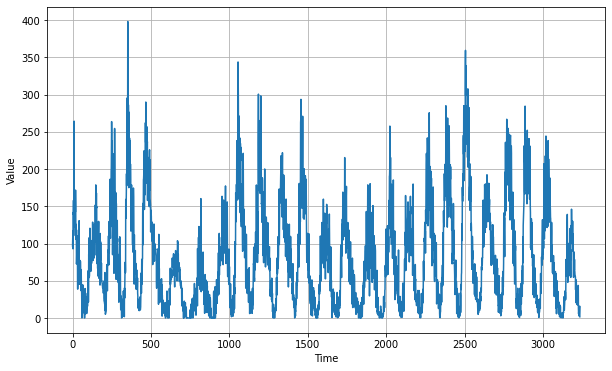

In [7]:
plt.figure(figsize=(10,6))
plot_series(time, series)

Split the Data into Training and Testing

In [8]:
# Mau di Ubah Split Time silakan
split_time = int(len(series) * 0.85)
t_train = time[1:split_time]
X_train = series[1:split_time]
t_valid = time[split_time:]
X_valid = series[split_time:]

Make a Windowed dataset function

Windowed dataset function = Function to take in a series and return windowed data that can be fed in for training

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  # Code here
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(size = window_size + 1, shift = 1, drop_remainder = True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.shuffle(buffer_size = shuffle_buffer)
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

Make a forecasting function

In [10]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window : window.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

Create train set

In [11]:
# Mau di Hyperparameter Tuning silakan
tf.keras.backend.clear_session()
window_size = 60
batch_size = 64

train_set = windowed_dataset(X_train, window_size, batch_size, 10) # Code here

print(train_set)
print(X_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
(2748,)


Create Model

In [12]:
# Mau di Ubah silakan
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
loss = tf.keras.losses.Huber()
metrics = ['mae']
epochs = 50

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Lambda, SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPool1D

def create_model_single(window_size):
  model = Sequential([Dense(1, input_shape = [window_size])])
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

def create_model_deep(window_size):
  model = Sequential([
    Dense(64, input_shape = [window_size], activation = "relu"),
    Dense(64, input_shape = [window_size], activation = "relu"),
    Dense(1)
  ])
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

def create_model_RNN(window_size):
  model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    SimpleRNN(64, return_sequences = True),
    SimpleRNN(64),
    Dense(1)
  ])
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

def create_model_GRU(window_size):
  model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    Bidirectional(GRU(64, return_sequences=True)),
    Bidirectional(GRU(64)),
    Dense(1)
  ])
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

def create_model_LSTM(window_size):
  model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[window_size]),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(1)
  ])
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

def create_model_conv(window_size):
  model = Sequential([
    Conv1D(filters=64, kernel_size=3, strides=1, activation="relu", 
           padding='causal', input_shape=[window_size, 1]),
    MaxPool1D(2),
    Conv1D(filters=128, kernel_size=3, strides=1, activation="relu", 
           padding='causal', input_shape=[window_size, 1]),
    MaxPool1D(2),
    Dense(64, activation="relu"),
    Dense(1)
  ])
  model.compile(optimizer = optimizer, loss = loss, metrics = metrics)
  return model

In [14]:
model_single  = create_model_single(window_size)
model_deep    = create_model_deep(window_size)
model_RNN     = create_model_RNN(window_size)
model_GRU     = create_model_GRU(window_size)
model_LSTM    = create_model_LSTM(window_size)
model_conv    = create_model_conv(window_size)

models = [model_single, model_deep, model_RNN, model_GRU, model_LSTM, model_conv]

Fit Model

In [15]:
def train_model(model, train_set, epochs):
  return model.fit(train_set, epochs = epochs, verbose = 0)

In [16]:
history_list = [train_model(model, train_set, epochs) for model in models]

Predict on test/val data and Plot Corresponding Graph

In [17]:
def create_graph(model, series, window_size):
  rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
  rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]
  if len(rnn_forecast.shape) == 2: 
    rnn_forecast = rnn_forecast.flatten()

  plt.figure(figsize=(10, 6))
  plot_series(t_valid, X_valid)
  plot_series(t_valid, rnn_forecast)

  # print(rnn_forecast.shape)
  MAE = tf.keras.metrics.mean_absolute_error(X_valid, rnn_forecast).numpy()
  print(f"MAE = {MAE}")

MAE = 17.90569305419922
MAE = 17.833547592163086
MAE = 80.41866302490234
MAE = 76.7624282836914
MAE = 84.90778350830078
MAE = 36.43659973144531


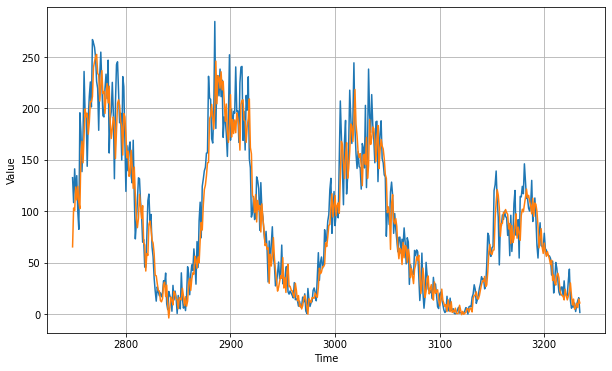

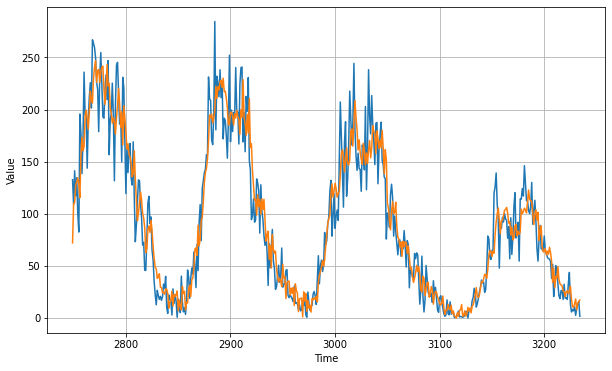

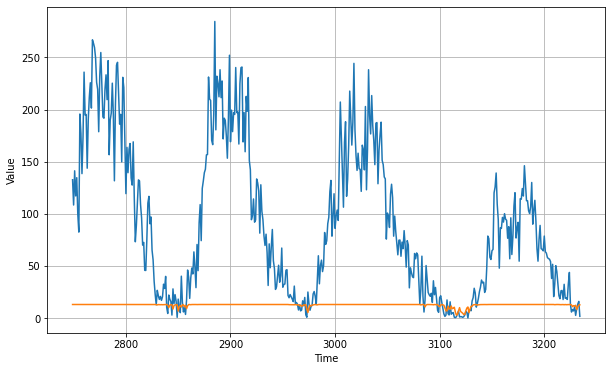

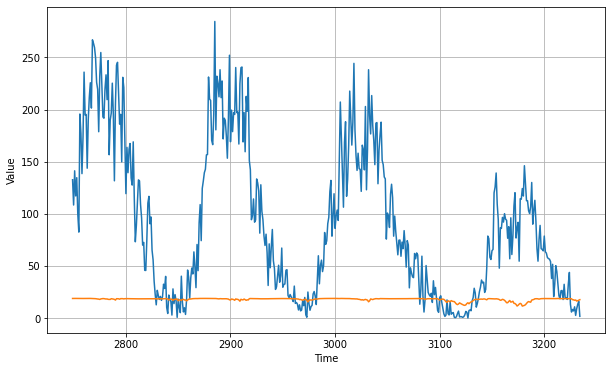

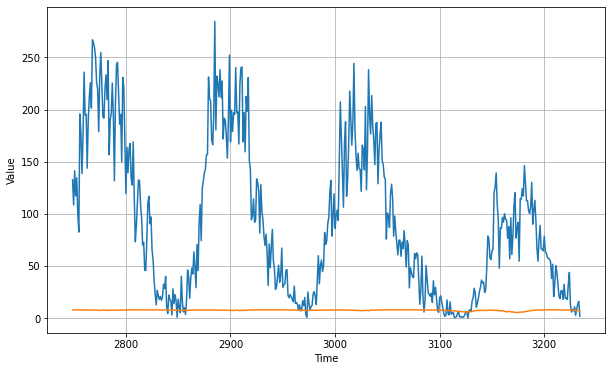

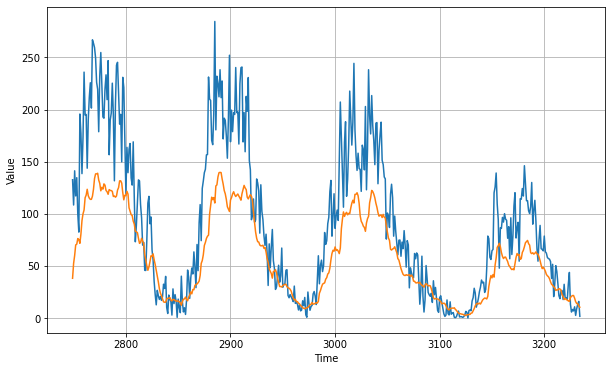

In [18]:
for i in range(len(models)):
  create_graph(models[i], series, window_size)

Plot Training Loss

In [19]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------

def plot_training_loss(history, metric):
  loss=history.history[metric]

  epochs=range(len(loss)) # Get number of epochs

  #------------------------------------------------
  # Plot training and validation loss per epoch
  #------------------------------------------------
  plt.plot(epochs, loss, 'r')
  plt.title(f'Training {metric}')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric])

  plt.figure()

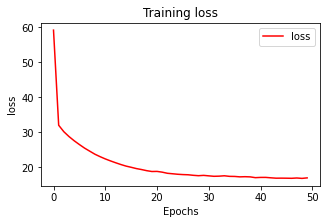

<Figure size 432x288 with 0 Axes>

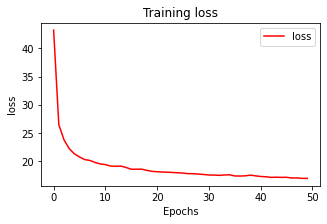

<Figure size 432x288 with 0 Axes>

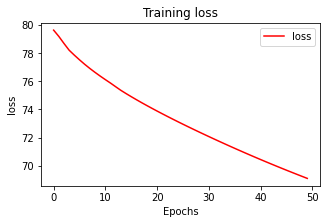

<Figure size 432x288 with 0 Axes>

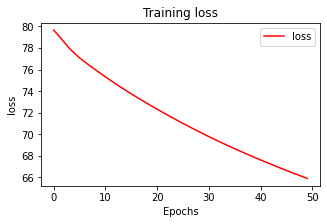

<Figure size 432x288 with 0 Axes>

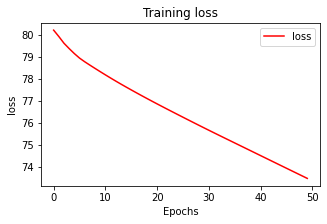

<Figure size 432x288 with 0 Axes>

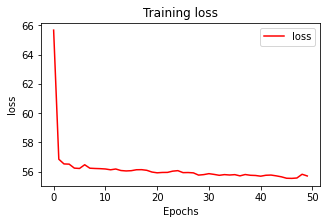

<Figure size 432x288 with 0 Axes>

In [20]:
for history in history_list:
  plt.figure(figsize = (5, 3))
  plot_training_loss(history, "loss")

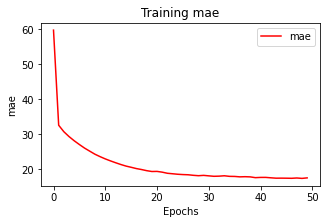

<Figure size 432x288 with 0 Axes>

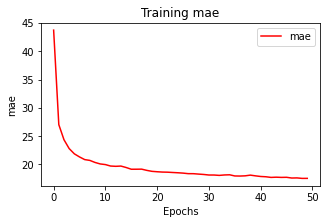

<Figure size 432x288 with 0 Axes>

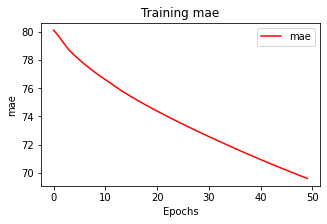

<Figure size 432x288 with 0 Axes>

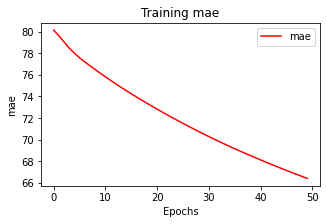

<Figure size 432x288 with 0 Axes>

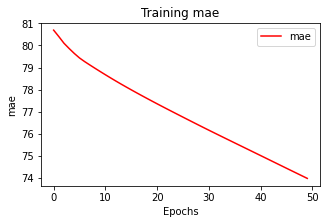

<Figure size 432x288 with 0 Axes>

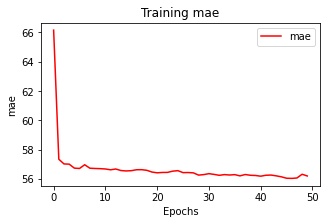

<Figure size 432x288 with 0 Axes>

In [21]:
for history in history_list:
  plt.figure(figsize = (5, 3))
  plot_training_loss(history, "mae")